In [1]:
import pandas as pd
from tqdm.auto import tqdm
import actions
from pathlib import Path
from utils import *
import re
from tqdm.auto import tqdm
import json
from concurrent.futures import ThreadPoolExecutor

C:\Users\voelk\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the file paths
parquet_file_abcd = Path("../data/ABCD_tripfiles.parquet")
parquet_file_abcd_conv = Path("../data/ABCD_tripfiles_conv.parquet")
parquet_file_mnop = Path("../data/MNOP_tripfiles.parquet")
parquet_file_mnop_conv = Path("../data/MNOP_tripfiles_conv.parquet")
parquet_file_zyxw = Path("../data/ZYXW_tripfiles.parquet")
parquet_file_zyxw_conv = Path("../data/ZYXW_tripfiles_conv.parquet")
print(
    parquet_file_abcd,
    parquet_file_abcd_conv,
    parquet_file_mnop,
    parquet_file_mnop_conv,
    parquet_file_zyxw,
    parquet_file_zyxw_conv,
)

..\data\ABCD_tripfiles.parquet ..\data\ABCD_tripfiles_conv.parquet ..\data\MNOP_tripfiles.parquet ..\data\MNOP_tripfiles_conv.parquet ..\data\ZYXW_tripfiles.parquet ..\data\ZYXW_tripfiles_conv.parquet


In [3]:
df_abcd = pd.read_parquet(parquet_file_abcd)
df_mnop = pd.read_parquet(parquet_file_mnop)
df_zyxw = pd.read_parquet(parquet_file_zyxw)

In [4]:
print(round(df_abcd.memory_usage(deep=True).sum() / 1024**2, 2), "MB")
print(round(df_mnop.memory_usage(deep=True).sum() / 1024**2, 2), "MB")
print(round(df_zyxw.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

1214.94 MB
2219.62 MB
585.54 MB


In [5]:
action_names = set(df_abcd.action_name.unique())
print(len(action_names))
action_names.update(set(df_mnop.action_name.unique()))
print(len(action_names))
action_names.update(set(df_zyxw.action_name.unique()))
print(len(action_names))

49
62
67


In [6]:
from actions import (
    CalculateWeightAndTrimAction,
    CheckinMsgProcessor,
    CreateLoadingInstructionAction,
    CreateLoadSheetAction,
    CreateZFWMessageAction,
    EstimateStorePaxDataAction,
    EstimateStorePaxDataAction,
    RampFinalAction,
    SendFuelOrderAction,
    SendLoadingInstructionAction,
    SendLoadsheetAction,
    SetActualBagWeightIndicatorAction,
    SetCKIPaxDistributionAction,
    # SpecialPaxWeightAction,
    # StoreAircraftDataAction,
    StorePaxDataAction,
    StoreRegistrationAndConfigurationAc,
    TdmCreateLoadingInstructionAction,
    TransferCargoAction,
    TransferCheckinDataAction,
    UpdateEstimatesAction,
    UpdateFuelDataAction,
    UpdateLoadTableAction,
    UpdateTransitLoadTableAction,
)

In [7]:
action_extractors = {
    "CalculateWeightAndTrimAction": CalculateWeightAndTrimAction.extract,
    "CheckinMsgProcessor": CheckinMsgProcessor.extract,
    "CreateLoadingInstructionAction": CreateLoadingInstructionAction.extract,
    "CreateLoadSheetAction": CreateLoadSheetAction.extract,
    "CreateZFWMessageAction": CreateZFWMessageAction.extract,
    "EstimateStorePaxDataAction": EstimateStorePaxDataAction.extract,
    "RampFinalAction": RampFinalAction.extract,
    "SendFuelOrderAction": SendFuelOrderAction.extract,
    "SendLoadingInstructionAction": SendLoadingInstructionAction.extract,
    "SendLoadsheetAction": SendLoadsheetAction.extract,
    "SetActualBagWeightIndicatorAction": SetActualBagWeightIndicatorAction.extract,
    "SetCKIPaxDistributionAction": SetCKIPaxDistributionAction.extract,
    # TODO "SpecialPaxWeightAction": SpecialPaxWeightAction.extract,  # missing
    # TODO "StoreAircraftDataAction": StoreAircraftDataAction.extract,  # BUG
    "StorePaxDataAction": StorePaxDataAction.extract,
    "StorePaxDataGuiAction": StorePaxDataAction.extract,
    "StoreRegistrationAndConfigurationAc": StoreRegistrationAndConfigurationAc.extract,
    "TdmCreateLoadingInstructionAction": TdmCreateLoadingInstructionAction.extract,
    "TransferCargoAction": TransferCargoAction.extract,
    "TransferCheckinDataAction": TransferCheckinDataAction.extract,
    "UpdateEstimatesAction": UpdateEstimatesAction.extract,
    "UpdateFuelDataAction": UpdateFuelDataAction.extract,
    "UpdateLoadTableAction": UpdateLoadTableAction.extract,
    "UpdateTransitLoadTableAction": UpdateTransitLoadTableAction.extract,
}

In [8]:
def extract_df(df: pd.DataFrame, progress_bar: bool = False, df_name: str = None):
    if progress_bar:
        tqdm.pandas()
    for action_name, extractor in action_extractors.items():

        if extractor is not None:
            if df_name:
                print(df_name, action_name)
            else:
                print(action_name)
            if progress_bar:
                df[f"data_{action_name}"] = df[df.action_name == action_name][
                    "entry_details"
                ].progress_apply(extractor)
            else:
                df[f"data_{action_name}"] = df[df.action_name == action_name][
                    "entry_details"
                ].apply(extractor)
    return df

In [9]:
def process_data(df, file_path, label):

    print(label)
    df_conv = extract_df(df)
    df_conv.to_parquet(file_path, engine="pyarrow", compression="brotli")



# Create a ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=3) as executor:
    futures = [
        executor.submit(process_data, df_abcd, parquet_file_abcd_conv, "ABCD"),
        executor.submit(process_data, df_mnop, parquet_file_mnop_conv, "MNOP"),
        executor.submit(process_data, df_zyxw, parquet_file_zyxw_conv, "ZYXW"),
    ]

    # Optional: Wait for all futures to complete
    for future in futures:
        future.result()  # This will re-raise any exceptions that occurred during task execution


ABCD
CalculateWeightAndTrimAction
MNOP
CalculateWeightAndTrimAction
ZYXW
CalculateWeightAndTrimAction
CheckinMsgProcessor
CreateLoadingInstructionAction
CreateLoadSheetAction
CreateZFWMessageAction
EstimateStorePaxDataAction
RampFinalAction
CheckinMsgProcessor
SendFuelOrderAction
SendLoadingInstructionAction
SendLoadsheetAction
SetActualBagWeightIndicatorAction
SetCKIPaxDistributionAction
StorePaxDataAction
CreateLoadingInstructionAction
CreateLoadSheetAction
CreateZFWMessageAction
EstimateStorePaxDataAction
RampFinalAction
SendFuelOrderAction
SendLoadingInstructionAction
SendLoadsheetAction
SetActualBagWeightIndicatorAction
StorePaxDataGuiAction
SetCKIPaxDistributionAction
StoreRegistrationAndConfigurationAc
StorePaxDataAction
TdmCreateLoadingInstructionAction
TransferCargoAction
TransferCheckinDataAction
UpdateEstimatesAction
UpdateFuelDataAction
UpdateLoadTableAction
UpdateTransitLoadTableAction
CheckinMsgProcessor
CreateLoadingInstructionAction
CreateLoadSheetAction
CreateZFWMessag

In [17]:
# print("ABCD")
# df_abcd_conv = extract_df(df_abcd, progress_bar=True)
# df_abcd_conv.to_parquet(parquet_file_abcd_conv, engine="pyarrow", compression="brotli")
# print("MNOP")
# df_mnop_conv = extract_df(df_mnop, progress_bar=True)
# df_mnop_conv.to_parquet(parquet_file_mnop_conv, engine="pyarrow", compression="brotli")
# print("ZYXW")
# df_zyxw_conv = extract_df(df_zyxw, progress_bar=True)
# df_zyxw_conv.to_parquet(parquet_file_zyxw_conv, engine="pyarrow", compression="brotli")

In [10]:
from pprint import pprint

In [11]:
# pprint(
#     df_abcd_conv[df_abcd_conv.action_name == "UpdateLoadTableAction"][
#         "entry_details"
#     ].iloc[1]
# )
# pprint(
#     json.loads(
#         df_abcd_conv[df_abcd_conv.action_name == "UpdateLoadTableAction"][
#             "data_UpdateLoadTableAction"
#         ].iloc[1]
#     )
# )

In [29]:
df = df_abcd


x = df[
    (df.action_name == "UpdateEstimatesAction")
    # & (~df["entry_details"].isnull())
    & (
        ~df["entry_details"].str.contains(
            "com.onesystem.lc2.estimateshandling.dto.EstimateWeightsDTO", na=False
        )
    )  # abcd
    & (
        ~df["entry_details"].str.contains(
            "com.systemone.lc2.estimateshandling.dto.EstimateWeightsDTO", na=False
        )
    )  # zyxw
    # & (
    #     ~df["entry_details"].str.contains("STATUS LOADING_INSTRUCTION", na=False)
    # )  # STATUS LOZYING_INSTRUCTION also included
    # & (~df["entry_details"].str.contains("STATUS LOZYING_INSTRUCTION", na=False))
    # & (
    #     ~df["entry_details"].str.contains("Email receivers", na=False)
    # )  # don't include this
    # & (
    #     ~df["entry_details"].str.contains("Telex receivers", na=False)
    # )  # don't include this
]["entry_details"].unique()

In [12]:
def parse(message):
    # Define all possible keys
    all_keys = {
        "AIRCRAFT_CONFIG",
        "AUTOMATION_STARTED",
        "AUTO_MODE_ACTIVE",
        "BAG_LOAD_ITEMS_GEN",
        "Bag Weight",
        "CABIN_CONFIG",
        "CALC_HIST_DATA",
        "CARGO_FINAL",
        "CARGO_TRANSFER",
        "CHECK_IN_OPEN",
        "Cargo",
        "DGR_ITEMS",
        "DOW",
        "EZFW",
        "EZFW_COUNTER",
        "FUEL",
        "FUEL_ORDER",
        "Mail",
        "OFP",
        "Pax Weight",
        "REGISTRATION",
        "REGISTRATION_CHANGE",
        "TRANSIT_ACCEPTANCE",
        "TRANSIT_PAX",
        "Weight Unit",
        "ZFW",
    }

    # Initialize the dictionary with None for all keys
    key_value_pairs = {key: None for key in all_keys}

    # Split the message into two parts
    parts = message.split("\r\n")
    main_part = parts[0]
    status_part = parts[1]

    # Define the expected keywords and units for weights
    weight_keywords = ["Pax Weight", "Bag Weight", "Cargo", "Mail", "DOW", "ZFW"]

    # Process the weight-related part
    for keyword in weight_keywords:
        pattern = rf"{keyword}\s*=\s*([-+]?[0-9]*\.?[0-9]+)\s*([a-zA-Z]+)"
        match = re.search(pattern, main_part)
        if match:
            value, unit = match.groups()
            key_value_pairs[keyword] = (
                float(value.strip()) if "." in value.strip() else int(value.strip())
            )
            key_value_pairs["Weight Unit"] = (
                unit.strip()
            )  # Assuming only one unit is present in the message

    # Process the status-related part
    status_pairs = status_part.split()
    status_pairs.pop(0)  # Remove the 'STATUS' keyword

    for i in range(0, len(status_pairs), 2):
        if i + 1 < len(status_pairs):
            key = status_pairs[i]
            value = status_pairs[i + 1]
            # Convert value to int or float if it is a number
            if value.isdigit():
                value = int(value)
            else:
                try:
                    value = float(value)
                except ValueError:
                    pass
            key_value_pairs[key] = value

    return json.dumps(key_value_pairs, indent=4)

In [17]:
x[0]

'Pax Weight = 11850.0 KG Bag Weight = 1920.0 KG Cargo = 56.1 KG Mail = 0.0 KG DOW = 44584.0 KG ZFW = 56434.0 KG\r\nSTATUS FUEL 2 AIRCRAFT_CONFIG 1 EZFW 2 CARGO_TRANSFER 1 CABIN_CONFIG 1 CALC_HIST_DATA 1 AUTO_MODE_ACTIVE 1 AUTOMATION_STARTED 0 BAG_LOAD_ITEMS_GEN 1 EZFW_COUNTER 2 REGISTRATION 1 REGISTRATION_CHANGE 2'

In [30]:
import numpy

y = numpy.array([parse(xi) for xi in x])

In [31]:
y

array(['{\n    "REGISTRATION_CHANGE": 2,\n    "CARGO_TRANSFER": 1,\n    "BAG_LOAD_ITEMS_GEN": 1,\n    "DGR_ITEMS": null,\n    "FUEL": 2,\n    "FUEL_ORDER": null,\n    "CARGO_FINAL": null,\n    "Bag Weight": 1920.0,\n    "AUTO_MODE_ACTIVE": 1,\n    "CABIN_CONFIG": 1,\n    "DOW": 44584.0,\n    "AUTOMATION_STARTED": 0,\n    "Weight Unit": "KG",\n    "REGISTRATION": 1,\n    "EZFW": 2,\n    "ZFW": 56434.0,\n    "Mail": 0.0,\n    "EZFW_COUNTER": 2,\n    "AIRCRAFT_CONFIG": 1,\n    "Pax Weight": 11850.0,\n    "OFP": null,\n    "Cargo": 56.1,\n    "CALC_HIST_DATA": 1\n}',
       '{\n    "REGISTRATION_CHANGE": 3,\n    "CARGO_TRANSFER": 1,\n    "BAG_LOAD_ITEMS_GEN": 1,\n    "DGR_ITEMS": null,\n    "FUEL": null,\n    "FUEL_ORDER": null,\n    "CARGO_FINAL": null,\n    "Bag Weight": 2820.0,\n    "AUTO_MODE_ACTIVE": 1,\n    "CABIN_CONFIG": 1,\n    "DOW": 44831.0,\n    "AUTOMATION_STARTED": 0,\n    "Weight Unit": "KG",\n    "REGISTRATION": 1,\n    "EZFW": 2,\n    "ZFW": 58126.0,\n    "Mail": 0.0,\n   

In [ ]:
i += 1
print(x[i])

com.onesystem.lc2.manualloadplanning.dto.LoadDTO [ id = 2267100  flightId = 519057 legId = 544622  deleted = false  fragmentId = LoadFragment ]
BULK
 Item Id   Number       Status    Weight         Pieces    Volume    Origin    Onl.Sta.  Dest.     Category  Position  Confirmed  Remarks  
 7401920   NULL         ESTIMATE  0.00      KG   0         0.00      GAU       GAU       IXA       TB        NULL      false      
 7403680   NULL         ESTIMATE  94.00     KG   0         0.00      BLR       BLR       IXA       C         3         true      NULL 
 7401919   NULL         ESTIMATE  1025.00   KG   124       0.00      GAU       GAU       IXA       B         NULL      false      

Total baggage      : 1025.00  KG               
Total cargo        : 94.00    KG               
Total EIC          : 0.00     KG               
Total mail         : 0.00     KG               
STATUS FUEL 1 AIRCRAFT_CONFIG 1 EZFW 2 CARGO_TRANSFER 1 CABIN_CONFIG 1 TRANSIT_PAX 1 CALC_HIST_DATA 1 CHECK_IN_OPEN 1 AUT

In [ ]:
extract(x[i])

{'Header': {'id': '2260162',
  'flightId': '517852',
  'legId': '543264',
  'deleted': 'false',
  'fragmentId': 'LoadFragment'},
 'Bulk': [{'Item Id': '7375488',
   'Number': None,
   'Status': 'ESTIMATE',
   'Weight': 64.0,
   'Weight Unit': 'KG',
   'Pieces': None,
   'Volume': None,
   'Origin': 'BLR',
   'Onl.Sta.': 'BLR',
   'Dest.': 'IXA',
   'Category': 'C',
   'Position': '1',
   'Confirmed': True,
   'Remarks': 'AVI'},
  {'Item Id': '7375487',
   'Number': None,
   'Status': 'ESTIMATE',
   'Weight': 53.0,
   'Weight Unit': 'KG',
   'Pieces': None,
   'Volume': None,
   'Origin': 'BLR',
   'Onl.Sta.': 'BLR',
   'Dest.': 'IXA',
   'Category': 'C',
   'Position': '4',
   'Confirmed': True,
   'Remarks': None},
  {'Item Id': '7375676',
   'Number': None,
   'Status': 'ESTIMATE',
   'Weight': 1109.0,
   'Weight Unit': 'KG',
   'Pieces': None,
   'Volume': None,
   'Origin': 'GAU',
   'Onl.Sta.': 'GAU',
   'Dest.': 'IXA',
   'Category': 'C',
   'Position': '2',
   'Confirmed': False

In [ ]:
# x["data_UpdateEstimatesAction"] = x[x.action_name == "UpdateEstimatesAction"][
#     "entry_details"
# ].progress_apply(extract)

AttributeError: 'numpy.ndarray' object has no attribute 'action_name'

In [ ]:
x = df_abcd.copy()

In [ ]:
bar = pd.read_parquet(parquet_file_zyxw_conv)

In [ ]:
bar.columns

Index(['id', 'creation_time', 'airline_code', 'flight_number', 'flight_date',
       'departure_airport', 'user_name', 'action_name', 'header_line',
       'entry_details', 'data_UpdateFuelDataAction', 'data_RampFinalAction',
       'data_CreateLoadingInstructionAction',
       'data_EstimateStorePaxDataAction', 'data_SendLoadingInstructionAction',
       'data_SetCKIPaxDistributionAction',
       'data_TdmCreateLoadingInstructionAction', 'data_UpdateEstimatesAction'],
      dtype='object')

In [ ]:
filtered_data = [item for item in x if "Discrepancy check result" in item]

In [ ]:
x = bar[~bar.data_SetCKIPaxDistributionAction.isna()]

In [ ]:
list(x.data_SetCKIPaxDistributionAction.apply(json.loads))

[{'TOTAL Pax': 6,
  'Y': 6,
  'Jump': 0,
  'StandBy': None,
  'Male': 2,
  'Female': 2,
  'Child': 2,
  'Infant': 0,
  'Total bag': 6,
  'Total bag weight': 72.0,
  'Baggage weight type': 'HISTORIC',
  'Weight unit': 'KG',
  'Sections': {'0A': {'Capacity': 'Y72', 'Distribution': 'Y0'},
   '0C': {'Capacity': 'Y102', 'Distribution': 'Y0'}},
  'Distribution': 'CKI_DISTRIBUTION'},
 {'TOTAL Pax': None,
  'Y': 0,
  'Jump': None,
  'StandBy': None,
  'Male': None,
  'Female': None,
  'Child': None,
  'Infant': None,
  'Total bag': 0,
  'Total bag weight': 0.0,
  'Baggage weight type': 'HISTORIC',
  'Weight unit': 'KG',
  'Sections': {'0A': {'Capacity': 'Y58', 'Distribution': 'Y0'},
   '0C': {'Capacity': 'Y60', 'Distribution': 'Y0'}},
  'Distribution': 'CKI_DISTRIBUTION'},
 {'TOTAL Pax': None,
  'Y': 0,
  'Jump': None,
  'StandBy': None,
  'Male': None,
  'Female': None,
  'Child': None,
  'Infant': None,
  'Total bag': 0,
  'Total bag weight': 0.0,
  'Baggage weight type': 'HISTORIC',
  'Weig

In [ ]:
list(x.data_UpdateEstimatesAction.apply(json.loads))

TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [ ]:
foobar = [
    item[list(item.keys())[13]]
    for item in list(x.data_SetCKIPaxDistributionAction.apply(json.loads))
    if len(item.keys()) > 11
    # if "HISTORIC" not in item["Baggage weight type"]
]

In [ ]:
import matplotlib.pyplot as plt

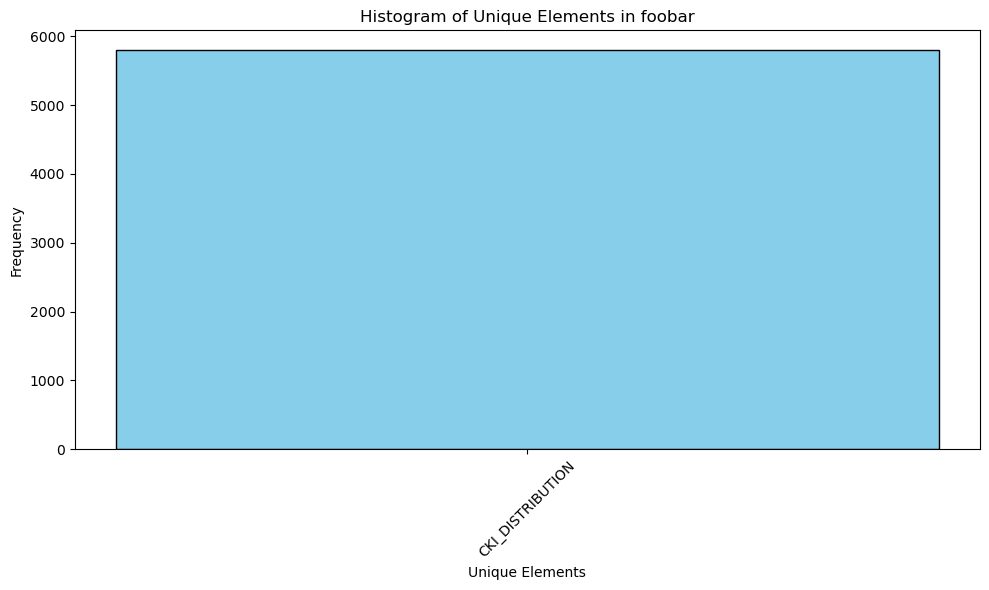

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample list with mixed types
# foobar = [1, 2, 'apple', 2, 'banana', 'apple', 4, 'banana', 'carrot', 5, 6, 'apple']

# Count the frequency of each unique element
frequency = Counter(foobar)

# Extract unique elements and their counts, convert elements to strings
unique_elements = list(map(str, frequency.keys()))
counts = list(frequency.values())

# Plot the histogram (bar chart)
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.bar(unique_elements, counts, color="skyblue", edgecolor="black")

# Add titles and labels for better readability
plt.title("Histogram of Unique Elements in foobar")
plt.xlabel("Unique Elements")
plt.ylabel("Frequency")

# Rotate the x-axis labels if they overlap
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [ ]:
set(foobar)

{0.0,
 126.0,
 144.0,
 1712.0,
 189.0,
 24.0,
 260.0,
 32.0,
 3552.0,
 357.0,
 360.0,
 3680.0,
 4000.0,
 460.0,
 4680.0,
 522.0,
 5960.0,
 60.0,
 702.0,
 72.0,
 924.0,
 'ACTUAL',
 'HISTORIC',
 'KG'}